In [1]:
using QuantumOptics, DiffEqNoiseProcess, PyPlot, Random, DelimitedFiles, NPZ, Printf, LinearAlgebra, DifferentialEquations, SpecialFunctions, SparseArrays, StatsBase, Optim, JLD2, BenchmarkTools
include("HenryLib.jl");

In [13]:
sb = SpinBasis(10//2)
sm = sigmam(sb)

Operator(dim=11x11)
  basis: Spin(5)sparse([2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ComplexF64[3.1622776601683795 + 0.0im, 4.242640687119285 + 0.0im, 4.898979485566356 + 0.0im, 5.291502622129181 + 0.0im, 5.477225575051661 + 0.0im, 5.477225575051661 + 0.0im, 5.291502622129181 + 0.0im, 4.898979485566356 + 0.0im, 4.242640687119285 + 0.0im, 3.1622776601683795 + 0.0im], 11, 11)

In [17]:
sm.data

11×11 SparseMatrixCSC{ComplexF64, Int64} with 10 stored entries:
         ⋅              ⋅              ⋅      …          ⋅          ⋅    
 3.16228+0.0im          ⋅              ⋅                 ⋅          ⋅    
         ⋅      4.24264+0.0im          ⋅                 ⋅          ⋅    
         ⋅              ⋅      4.89898+0.0im             ⋅          ⋅    
         ⋅              ⋅              ⋅                 ⋅          ⋅    
         ⋅              ⋅              ⋅      …          ⋅          ⋅    
         ⋅              ⋅              ⋅                 ⋅          ⋅    
         ⋅              ⋅              ⋅                 ⋅          ⋅    
         ⋅              ⋅              ⋅                 ⋅          ⋅    
         ⋅              ⋅              ⋅                 ⋅          ⋅    
         ⋅              ⋅              ⋅      …  3.16228+0.0im      ⋅    

In [23]:
findnz(sm.data)

([2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ComplexF64[3.1622776601683795 + 0.0im, 4.242640687119285 + 0.0im, 4.898979485566356 + 0.0im, 5.291502622129181 + 0.0im, 5.477225575051661 + 0.0im, 5.477225575051661 + 0.0im, 5.291502622129181 + 0.0im, 4.898979485566356 + 0.0im, 4.242640687119285 + 0.0im, 3.1622776601683795 + 0.0im])

In [33]:
(1,)

(1,)

In [63]:
import Base: ==, +, -, *, /, length, copy, eltype
function *(sp_mtrx::SparseMatrixCSC, v::Union{<: SizedArray, <: SVector})
    rslt = SizedArray{Tuple{size(sm.data,1)}}(zeros(size(sm.data,1)))
    for I = findall(!iszero, sm.data)
        s[I[1]] += sm.data[I]*v[I[2]]
    end
    return rslt
end

* (generic function with 959 methods)

In [71]:
v1 = SizedArray{Tuple{11}}(spindown(sb).data)
v2 = SizedArray{Tuple{11}}(spinup(sb).data)
m1 = sm.data

println(m1*v1, m1*v2)
alloc_v1 = @allocated v1
alloc_v2 = @allocated v2
alloc_m1 = @allocated m1
println(alloc_v1, alloc_v2, alloc_m1)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0][0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
000


In [54]:
s

11-element SizedVector{11, Float64, Vector{Float64}} with indices SOneTo(11):
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [16]:
a = SVector{11, ComplexF64}(zeros(11))
b = SVector{5, ComplexF64}(zeros(5))
kron(a,b);
function *(a::SparseMatrixCSC{T, B}, b::SVector{N, T}) where {T,N,B}
    @assert size(a,2) == N
end
sm.data * a

11-element Vector{ComplexF64}:
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [9]:
spindown(sb).data

11-element Vector{ComplexF64}:
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 1.0 + 0.0im

In [ ]:
using QuantumOptics, DiffEqNoiseProcess, PyPlot, DifferentialEquations, SparseArrays, StaticArrays, BenchmarkTools

function smoothstep!(x)
    if x < 0
        return 0
    elseif x > 1
        return 1
    else
        return 3*x^2 - 2*x^3
    end
end

Nspin = 10
κ = 2π*0.15 # MHz
Δc = 2π*20 # MHz
ωz = 2π*0.01 # MHz
seed = 1729
tmax = 50.0 # μs
recordtimes = 50
tspan = range(0.0, tmax, recordtimes)

sb = SpinBasis(Nspin // 2)
Sx = sigmax(sb) / 2
Sy = sigmay(sb) / 2
Sz = sigmaz(sb) / 2
idOp = identityoperator(sb)
ψ0 = spindown(sb)
ψ0 = normalize!(ψ0)
Q0 = 40. # charge on the photodiode at time 0
cl0 = ComplexF64[Q0]
ψ_sc0 = semiclassical.State(ψ0, cl0)

stateG = copy(ψ_sc0)
dstateG = copy(ψ_sc0)
Nq = length(ψ_sc0.quantum)
Nc = length(ψ_sc0.classical)
Ntot = Nq + Nc
u0 = zeros(ComplexF64, Ntot)
semiclassical.recast!(u0, ψ_sc0)
# u0 = zeros(ComplexF64, Ntot)
# semiclassical.recast!(u0, ψ_sc0)
gc = sqrt(ωz*(Δc^2 + κ^2)/abs(Nspin*Δc))
grel!(t) = 1.1*smoothstep!(t/200.)

αplus = Δc/(-Δc + ωz - im*κ) + Δc/(-Δc - ωz - im*κ)
αminus = Δc/(-Δc + ωz - im*κ) - Δc/(-Δc - ωz - im*κ)

C0 = gc*sqrt(κ)/(2*Δc)*(αplus*Sx+im*αminus*Sy)
C!(t) = grel!(t)*C0

H0T1 = ωz*Sz
H0T2 = (gc)^2/(4*Δc)*Sx*(2*real(αplus)*Sx-2*imag(αminus)*Sy)
function H0!(t)
    return H0T1 - H0T2*(grel!(t))^2
end
function H_nl!(ψ,t)
    Ct = C!(t)
    return im * expect(dagger(Ct), normalize(ψ)) * Ct - 0.5im * dagger(Ct) * Ct - 0.5im * expect(dagger(Ct), normalize(ψ)) * expect(Ct, normalize(ψ)) * idOp
end
fdet_heterodyne!(t, ψ) = H0!(t) + H_nl!(ψ, t)
function fst_heterodyne!(t, ψ)
    Ct = C!(t)
    return [(Ct - expect(Ct, normalize(ψ)) * idOp)/sqrt(2), im/sqrt(2)*(Ct - expect(Ct, normalize(ψ)) * idOp)]
end

function f!(du, u, p, t)
    semiclassical.recast!(dstateG, du)
    semiclassical.recast!(stateG, u)
    timeevolution.dschroedinger_dynamic!(dstateG.quantum, fdet_heterodyne!, stateG.quantum, t)
    dstateG.classical[1] = expect(C!(t), stateG.quantum)
    semiclassical.recast!(du, dstateG)
end

num_noise = length(fst_heterodyne!(0., ψ_sc0.quantum))
noise_prototype = zeros(ComplexF64, (Ntot, num_noise))

function g!(du, u, p, t)
    semiclassical.recast!(stateG, u)
    dx = @view du[1:Nq,:]
    stochastic.dschroedinger_stochastic(dx, t, stateG.quantum, fst_heterodyne!, dstateG.quantum, num_noise)
    du[Nq+1, 1] = 1.0
    du[Nq+1, 2] = 1.0im
    du
end

Base.@pure pure_inference(fout,T) = Core.Compiler.return_type(fout, T)

function fout(t, state)
    copy(state)
end
function fout_(x, t, integrator)
    semiclassical.recast!(stateG,x)
    copy(stateG)
end

out_type = pure_inference(fout, Tuple{eltype(tspan),typeof(ψ_sc0)})
out = DiffEqCallbacks.SavedValues(eltype(tspan),out_type)
scb = DiffEqCallbacks.SavingCallback(fout_,out,saveat=tspan,
                                         save_everystep=true,
                                         save_start = false,
                                         tdir = first(tspan)<last(tspan) ? one(eltype(tspan)) : -one(eltype(tspan)))

sde_func = SDEFunction(f!,g!;)
prob = SDEProblem(sde_func, u0, (tspan[begin], tspan[end]); noise_rate_prototype=noise_prototype)
sol = solve(prob, WangLi3SMil_A();
            adaptive=false,
            dt=0.001,
            reltol = 1.0e-3,
            abstol = 1.0e-3,
            save_everystep = false, save_start = false,
            save_end = false,
            callback=scb, seed=seed)

tout = out.t
psi_t = out.saveval;

In [4]:
using StaticArrays
# MyVec = MArray{Tuple{10,1}}(zeros(ComplexF64, 10))
MyVec = SVector{10}(zeros(ComplexF64, 10))
# VecT = MArray{Tuple{10,1}}

10-element SVector{10, ComplexF64} with indices SOneTo(10):
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [ ]:
sb = SpinBasis(5//2)
ψ0 = spindown(sb)

In [79]:
typeof(spindown(ComplexF64, sb))

Ket{SpinBasis{5//1, Int64}, Vector{ComplexF64}}

In [80]:
@benchmark H0(1.0)

BenchmarkTools.Trial: 10000 samples with 9 evaluations.
 Range (min … max):  2.051 μs …  22.349 ms  ┊ GC (min … max):  0.00% … 99.96%
 Time  (median):     2.213 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   4.666 μs ± 223.488 μs  ┊ GC (mean ± σ):  49.52% ±  2.70%

    ▇█▄                                                        
  ▁▅███▆▄▄▄▃▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  2.05 μs         Histogram: frequency by time        3.88 μs <

 Memory estimate: 7.64 KiB, allocs estimate: 48.

In [16]:
H1=(ωz*Sz)
H2 = ((gc)^2/(4*Δc)*Sx*(2*real(αplus)*Sx-2*imag(αminus)*Sy))
H0(t) = H1 - H2*(grel(t))^2
@benchmark H0(1.0)

BenchmarkTools.Trial: 10000 samples with 192 evaluations.
 Range (min … max):  504.776 ns … 995.487 μs  ┊ GC (min … max):  0.00% … 99.92%
 Time  (median):     522.570 ns               ┊ GC (median):     0.00%
 Time  (mean ± σ):   670.463 ns ±   9.956 μs  ┊ GC (mean ± σ):  20.08% ±  8.40%

  ▃▇█▇▅▄▂▁▂▂▂▂▁▁ ▁  ▁▁▁▁▁                                       ▂
  ██████████████████████████▇▆▆▅▅▅▅▅▆▅▄▄▄▅▃▃▄▃▁▃▁▁▃▄▁▁▄▁▁▁▁▃▁▁▄ █
  505 ns        Histogram: log(frequency) by time        901 ns <

 Memory estimate: 2.47 KiB, allocs estimate: 13.

In [12]:
H1=(ωz*Sz)
H2 = ((gc)^2/(4*Δc)*Sx*(2*real(αplus)*Sx-2*imag(αminus)*Sy))
H0!(t) = H1 - H2*(grel(t))^2
@benchmark H0!(1.0)

BenchmarkTools.Trial: 10000 samples with 190 evaluations.
 Range (min … max):  519.300 ns …  1.003 ms  ┊ GC (min … max):  0.00% … 99.92%
 Time  (median):     545.395 ns              ┊ GC (median):     0.00%
 Time  (mean ± σ):   696.271 ns ± 10.035 μs  ┊ GC (mean ± σ):  19.52% ±  8.36%

   ▄▆█▇▅▄▃▂▂▃▂▃▂▂▁▂▂▂▂▂▁▁ ▁                                    ▂
  ██████████████████████████▇▇▇▇▆▆▆▆▅▆▄▆▅▆▃▄▃▃▃▃▄▃▁▁▃▃▃▁▁▁▃▁▃▄ █
  519 ns        Histogram: log(frequency) by time       907 ns <

 Memory estimate: 2.47 KiB, allocs estimate: 13.

In [5]:
@benchmark H1*ψ0

BenchmarkTools.Trial: 10000 samples with 963 evaluations.
 Range (min … max):   86.146 ns … 196.725 μs  ┊ GC (min … max):  0.00% … 99.94%
 Time  (median):      87.833 ns               ┊ GC (median):     0.00%
 Time  (mean ± σ):   113.113 ns ±   1.967 μs  ┊ GC (mean ± σ):  20.07% ±  6.19%

   ▄█▇▅▃▂▂▄▃▁         ▂▂▂▁▁▁▁▁   ▁                              ▁
  ▆████████████▇████▇██████████████▇▇▇█▇▇▇▇▆▆▇▅▆▆▆▆▆▄▄▅▄▄▅▅▄▄▄▅ █
  86.1 ns       Histogram: log(frequency) by time        117 ns <

 Memory estimate: 288 bytes, allocs estimate: 2.

In [6]:
H1S = H1.data
ψ0S = ψ0.data
@benchmark H1S*ψ0S

BenchmarkTools.Trial: 10000 samples with 972 evaluations.
 Range (min … max):  75.146 ns …  69.500 μs  ┊ GC (min … max): 0.00% … 99.79%
 Time  (median):     78.489 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   96.986 ns ± 713.075 ns  ┊ GC (mean ± σ):  7.81% ±  3.94%

  █                                                             
  █▄▄▃▃▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂ ▂
  75.1 ns         Histogram: frequency by time          197 ns <

 Memory estimate: 240 bytes, allocs estimate: 1.

In [14]:
@benchmark grel!(1.0)

BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):  0.916 ns … 5.125 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     0.958 ns             ┊ GC (median):    0.00%
 Time  (mean ± σ):   0.968 ns ± 0.049 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂             █             ▅             ▁▂            ▁ ▁
  █▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁█ █
  0.916 ns    Histogram: log(frequency) by time     1.08 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [76]:
@benchmark ωz*Sz

BenchmarkTools.Trial: 10000 samples with 501 evaluations.
 Range (min … max):  222.970 ns … 141.302 μs  ┊ GC (min … max): 0.00% … 99.76%
 Time  (median):     248.004 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   286.290 ns ±   1.426 μs  ┊ GC (mean ± σ):  8.44% ±  5.53%

     ▇█▆▃▂                                                       
  ▂▄███████▇▇▆▅▅▄▄▄▄▄▃▃▃▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  223 ns           Histogram: frequency by time          407 ns <

 Memory estimate: 656 bytes, allocs estimate: 6.

In [74]:
@benchmark fdet_heterodyne(1.0, ψ0)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  12.917 μs … 233.965 ms  ┊ GC (min … max):  0.00% … 99.98%
 Time  (median):     15.625 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   39.688 μs ±   2.339 ms  ┊ GC (mean ± σ):  58.94% ±  1.00%

   ▅█▃▂▂▂▆█▆▆▅▂                                                 
  ▃██████████████▇▅▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  12.9 μs         Histogram: frequency by time           30 μs <

 Memory estimate: 42.84 KiB, allocs estimate: 293.

In [18]:
function f!(du, u, p, t)
    dstateG.quantum.data = view(du, 1:Nq)
    dstateG.classical = view(du, Nq+1:Ntot)
    stateG.quantum.data = view(u, 1:Nq)
    stateG.classical = view(u, Nq+1:Ntot)
    # semiclassical.recast!(dstateG, du)
    # semiclassical.recast!(stateG, u)
    timeevolution.dschroedinger_dynamic!(dstateG.quantum, fdet_heterodyne, stateG.quantum, t)
    # dstateG.quantum.data[2] = - stateG.quantum.data[2]
    # dstateG.classical[1] = expect(C(t), stateG.quantum)
    # println(dstateG)
    # semiclassical.recast!(du, dstateG)
end

du = zeros(ComplexF64, Ntot)
f!(du, u0, nothing, 1.0)
println(du)

@benchmark f!(du, u0, nothing, 1.0)

ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]


BenchmarkTools.Trial: 10000 samples with 5 evaluations.
 Range (min … max):   5.883 μs …  39.402 ms  ┊ GC (min … max):  0.00% … 99.94%
 Time  (median):      6.258 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   10.989 μs ± 394.077 μs  ┊ GC (mean ± σ):  38.35% ±  3.72%

     █▅                                                         
  ▁▃███▇▃▃▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  5.88 μs         Histogram: frequency by time         10.2 μs <

 Memory estimate: 19.50 KiB, allocs estimate: 133.

In [19]:
function f!(du, u, p, t)
    semiclassical.recast!(dstateG, du)
    semiclassical.recast!(stateG, u)
    timeevolution.dschroedinger_dynamic!(dstateG.quantum, fdet_heterodyne, stateG.quantum, t)
    semiclassical.recast!(du, dstateG)
end

du = zeros(ComplexF64, Ntot)
f!(du, u0, nothing, 1.0)
println(du)

@benchmark f!(du, u0, nothing, 1.0)

ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, -5.353809859390876e-13 - 1.4248330824270901e-10im, 0.0 + 0.0im, -3.994478559194471e-13 + 0.31415926525277854im, 0.0 + 0.0im]


BenchmarkTools.Trial: 10000 samples with 6 evaluations.
 Range (min … max):  5.292 μs …  33.735 ms  ┊ GC (min … max):  0.00% … 99.94%
 Time  (median):     5.597 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   9.681 μs ± 337.359 μs  ┊ GC (mean ± σ):  37.66% ±  4.05%

  ▁▆█▇▆▄▄▄▄▃▂▂▂▂▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁                               ▂
  ████████████████████████████████▇██▇▇▇▇▆▆▆▆▇▅▇▆▆▅▆▅▅▆▄▄▆▃▂▄ █
  5.29 μs      Histogram: log(frequency) by time      10.2 μs <

 Memory estimate: 18.56 KiB, allocs estimate: 121.

In [14]:
@benchmark g!(zeros(ComplexF64, (Ntot,2)), u0, nothing, 1.0)

BenchmarkTools.Trial: 10000 samples with 3 evaluations.
 Range (min … max):   8.347 μs …  71.635 ms  ┊ GC (min … max):  0.00% … 99.95%
 Time  (median):      9.111 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   16.969 μs ± 716.368 μs  ┊ GC (mean ± σ):  43.94% ±  2.53%

     ██▅                                                        
  ▁▃█████▆▅▅▆▇▅▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  8.35 μs         Histogram: frequency by time         15.2 μs <

 Memory estimate: 23.45 KiB, allocs estimate: 178.

In [9]:
@benchmark sol = solve(prob, RKMilGeneral(;ii_approx=IICommutative()); adaptive=false, dt=0.01, reltol = 1.0e-3, abstol = 1.0e-3, save_everystep = false, save_start = false, save_end = false, seed=seed, callback=scb)

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.071 s …   1.153 s  ┊ GC (min … max): 11.46% … 14.59%
 Time  (median):     1.119 s              ┊ GC (median):    13.57%
 Time  (mean ± σ):   1.112 s ± 33.232 ms  ┊ GC (mean ± σ):  13.12% ±  1.36%

  █         █                      █       █              █  
  █▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.07 s         Histogram: frequency by time        1.15 s <

 Memory estimate: 2.19 GiB, allocs estimate: 15352338.

In [10]:
out.saveval

50501-element Vector{QuantumOptics.semiclassical.State{SpinBasis{5//1, Int64}, Ket{SpinBasis{5//1, Int64}, Vector{ComplexF64}}, Vector{ComplexF64}}}:
 QuantumOptics.semiclassical.State{SpinBasis{5//1, Int64}, Ket{SpinBasis{5//1, Int64}, Vector{ComplexF64}}, Vector{ComplexF64}}(Ket(dim=11)
  basis: Spin(5)
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 1.0 + 0.0im, ComplexF64[0.0 + 0.0im])
 QuantumOptics.semiclassical.State{SpinBasis{5//1, Int64}, Ket{SpinBasis{5//1, Int64}, Vector{ComplexF64}}, Vector{ComplexF64}}(Ket(dim=11)
  basis: Spin(5)
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 1.0 + 0.00314159265358979im, ComplexF64[0.04094134558289855 - 0.037190008370822036im])
 QuantumOptics.semiclassical.State{SpinBasis{5//1, Int64}, Ket{SpinBasis{5//1, Int64}, Vector{ComplexF64}}, Vector{ComplexF64}}(Ket(dim=11)
  basis: 

In [90]:
Base.summarysize(out.saveval)

352521136

In [91]:
@benchmark sol = solve(prob, EM(); adaptive=false, dt=0.01, reltol = 1.0e-3, abstol = 1.0e-3, save_everystep = false, save_start = false, save_end = false, callback=scb, seed=seed)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 20.397 s (24.51% GC) to evaluate,
 with a memory estimate of 34.97 GiB, over 255524544 allocations.

In [ ]:
field = map(n->expect(C(tout[n]), psi_t[n]), 1:length(tout))
plot(tout, real.(field), label="Real")
plot(tout, imag.(field), label="Imag")
# plot(tout, expect(Sx, psi_t_SOSRI2), label="SOSRI2")
# plot(tout, grel.(tout), linestyle="dashed")
legend()
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle C(t) \\rangle\$")
PyPlot.display_figs()

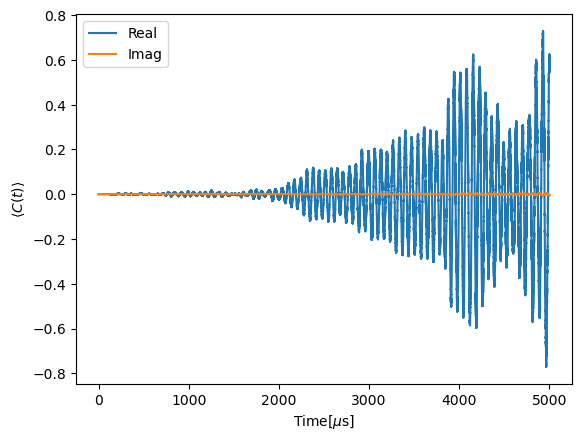

In [ ]:
field = map(n->expect(C(tout[n]), psi_t[n]), 1:length(tout))
plot(tout, real.(field), label="Real")
plot(tout, imag.(field), label="Imag")
# plot(tout, expect(Sx, psi_t_SOSRI2), label="SOSRI2")
# plot(tout, grel.(tout), linestyle="dashed")
legend()
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle C(t) \\rangle\$")
PyPlot.display_figs()

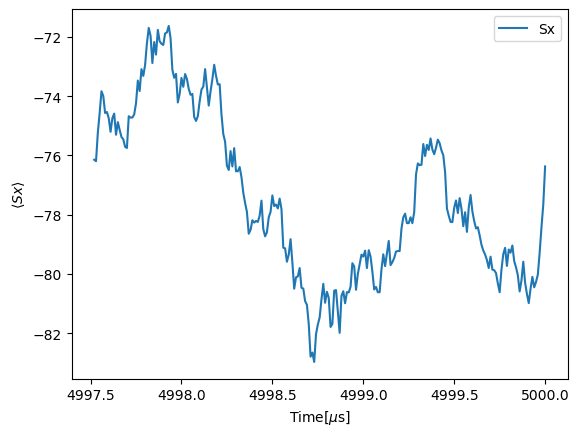

In [ ]:
plot(tout[end-500:end], expect(Sx, psi_t)[end-500:end], label="Sx")
# plot(tout, expect(Sx, psi_t_SOSRI2), label="SOSRI2")
# plot(tout, grel.(tout), linestyle="dashed")
legend()
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sx \\rangle\$")
PyPlot.display_figs()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


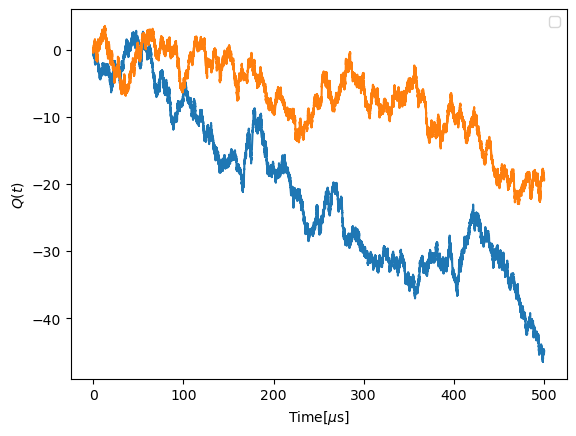

In [21]:
Q = map(x->x.classical[1], psi_t)
plot(tout, real.(Q))
plot(tout, imag.(Q))
# plot(tout, expect(Sx, psi_t_SOSRI2), label="SOSRI2")
# plot(tout, grel.(tout), linestyle="dashed")
legend()
xlabel("Time[\$\\mu\$s]")
ylabel("\$ Q(t)\$")
PyPlot.display_figs()

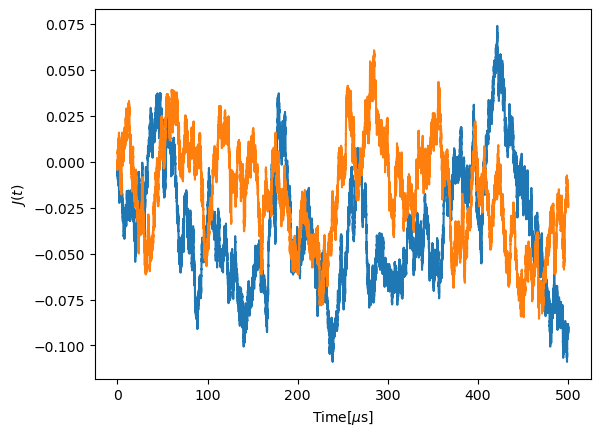

In [47]:
Q = map(x->x.classical[1], psi_t)
dt = tout[2] - tout[1]
J = (Q[2:end] - Q[1:end-1])/dt
Jfilt = exp_filter(J, 10000*dt, dt)
plot(tout[1:end-1], real.(Jfilt))
plot(tout[1:end-1], imag.(Jfilt))
# plot(tout, expect(Sx, psi_t_SOSRI2), label="SOSRI2")
# plot(tout, grel.(tout), linestyle="dashed")
# legend()
xlabel("Time[\$\\mu\$s]")
ylabel("\$ J(t)\$")
PyPlot.display_figs()

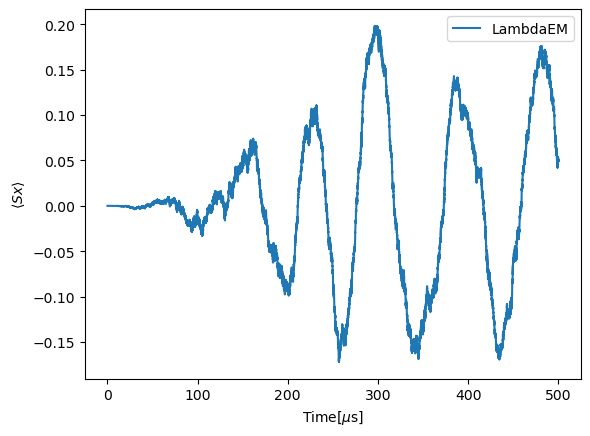

In [20]:
plot(tout, expect(Sx, psi_t), label="LambdaEM")
# plot(tout, expect(Sx, psi_t_SOSRI2), label="SOSRI2")
# plot(tout, 5/0.9*grel.(tout), linestyle="dashed")
legend()
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sx \\rangle\$")
PyPlot.display_figs()

In [15]:
diff = psi_t_SOSRI2[end] - psi_t_EM[end]
print(dagger(diff)*diff)

0.010472472731642386 + 9.356539586650395e-20im

In [ ]:
gc = sqrt(ωz*(Δc^2 + κ^2)/abs(Nspin*Δc))
grel(t) = 1.0 #0.9*smoothstep(t/200.)

αplus = Δc/(-Δc + ωz - im*κ) + Δc/(-Δc - ωz - im*κ)
αminus = Δc/(-Δc + ωz - im*κ) - Δc/(-Δc - ωz - im*κ)

C(t) = (grel(t)*gc)*sqrt(κ)/(2*Δc)*(αplus*Sx+im*αminus*Sy)
H0(t) = ωz*Sz - (grel(t)*gc)^2/(4*Δc)*Sx*(2*real(αplus)*Sx-2*imag(αminus)*Sy)
H_nl(ψ,t) = im * expect(dagger(C(t)), normalize(ψ)) * C(t) - 0.5im * dagger(C(t)) * C(t) - 0.5im * expect(dagger(C(t)), normalize(ψ)) * expect(C(t), normalize(ψ)) * idOp
fdet_heterodyne(t, ψ) = H0(t) + H_nl(ψ, t)
fst_heterodyne(t, ψ) = [C(t) - expect(C(t), normalize(ψ)) * idOp]

Z1 = WienerProcess(0.0, im * 0.0, im * 0.0)
#tout, psi_t_EM
tout, psi_t_EM = stochastic.schroedinger_dynamic(tspan, ψ0, fdet_heterodyne, fst_heterodyne; normalize_state=true, noise=Z1, seed=seed, alg=RKMilGeneral(), dt=0.0001, reltol=10^-4, abstol=10^-4, maxiters=10^8, adaptive=false);

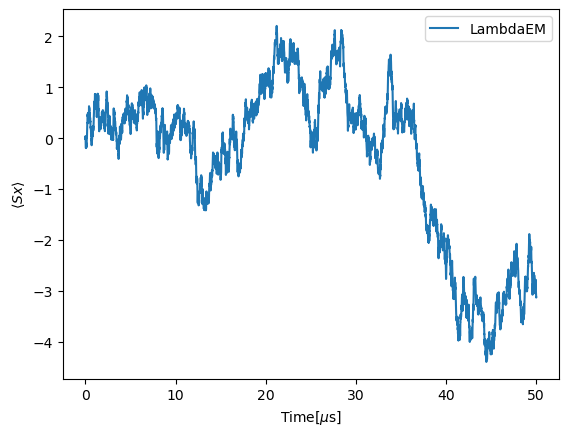

In [111]:
plot(tout, map(x->x.classical, psi_t), label="LambdaEM")
# plot(tout, expect(Sx, psi_t_SOSRI2), label="SOSRI2")
# plot(tout, 5/0.9*grel.(tout), linestyle="dashed")
legend()
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sx \\rangle\$")
PyPlot.display_figs()

In [52]:
using DiffEqNoiseProcess, SciMLBase, Plots
seed = 1337

Z1 = WienerProcess(0.0, im * 0.0, im * 0.0, reseed=false)
prob1 = NoiseProblem(Z1, (0.0, 10.0), seed=seed)
sol1 = solve(prob1; dt = 0.1)

Z2 = WienerProcess(0.0, im * 0.0, im * 0.0, reseed=false)
prob2 = NoiseProblem(Z2, (0.0, 10.0), seed=seed)
sol2 = solve(prob1; dt = 0.101);

plot(sol1.t, real.(sol1.u), label="Version 1")
Plots.savefig("V1.png")

plot(sol2.t, real.(sol2.u), label="Version 2")
Plots.savefig("V2.png");

"/Volumes/commondrive/Users/hshunt/LabNotebooks/DickeModel/V2.png"

In [6]:
(gc)^2/(4*Δc)

0.0015708846840882791

In [4]:
seed = Int(round(mod(time()*300,1000)))

280

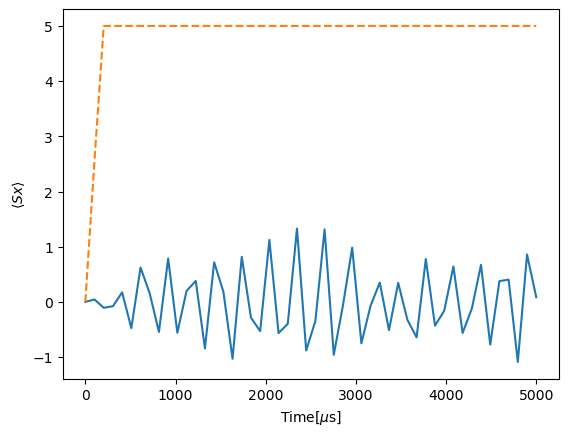

In [25]:
plot(tout, expect(Sx, psi_t))
plot(tout, 5/0.9*grel.(tout), linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sx \\rangle\$")
PyPlot.display_figs()

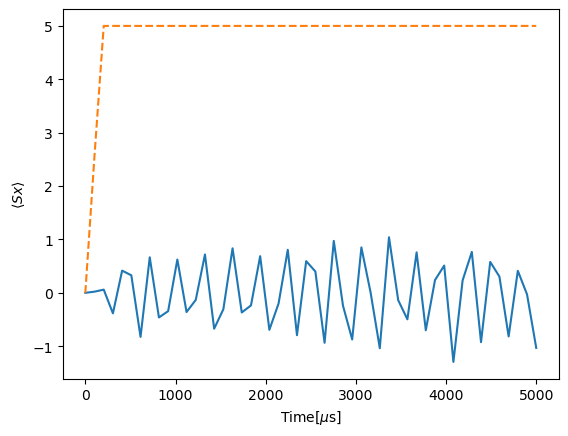

In [16]:
plot(tout, expect(Sx, psi_t))
plot(tout, 5/0.9*grel.(tout), linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sx \\rangle\$")
PyPlot.display_figs()

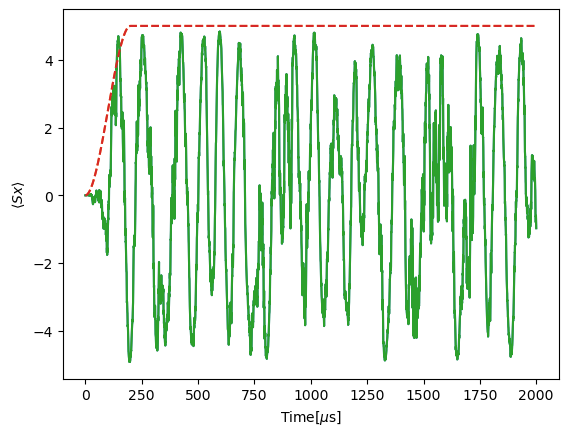

In [110]:
ax = gca()
ax.plot(tout, expect(Sx, psi_t))
ax.plot(tout, 5/0.9*λrelfnc.(tout), linestyle="dashed")
ax.set_xlabel("Time[\$\\mu\$s]")
ax.set_ylabel("\$\\langle Sx \\rangle\$")
PyPlot.display_figs()

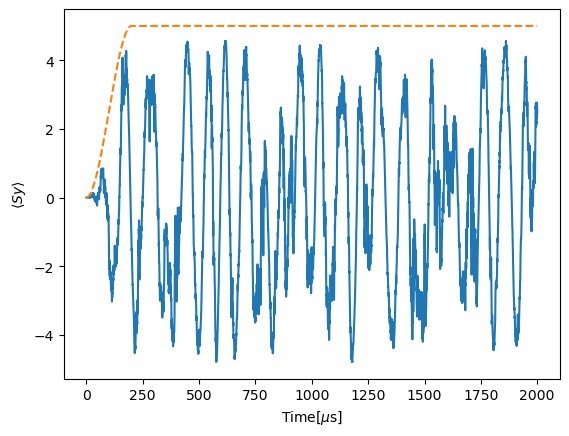

In [103]:
plot(tout, expect(Sy, psi_t))
plot(tout, 5/0.9*λrelfnc.(tout), linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sy \\rangle\$")
PyPlot.display_figs()

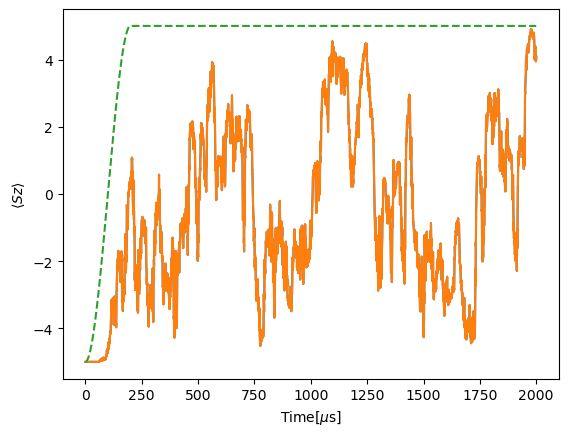

In [99]:
plot(tout, expect(Sz, psi_t))
plot(tout, 10/0.9*λrelfnc.(tout).-5, linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sz \\rangle\$")
PyPlot.display_figs()

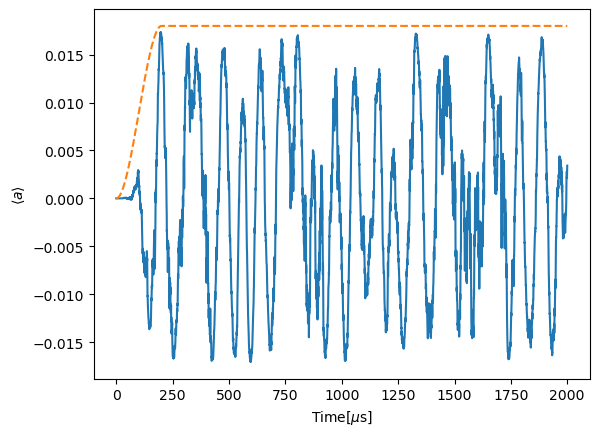

In [100]:
plot(tout, expect(a, psi_t))
plot(tout, 0.02*λrelfnc.(tout), linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle a \\rangle\$")
PyPlot.display_figs()

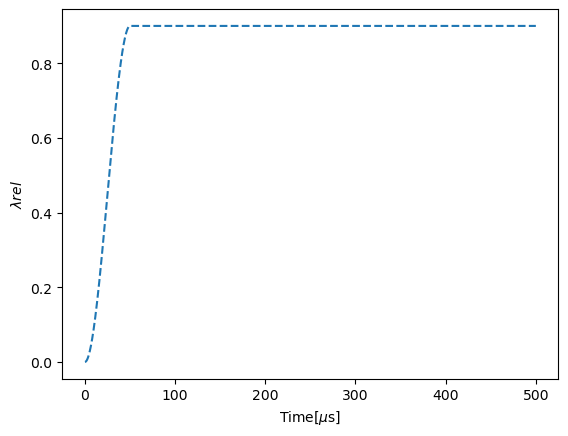

In [81]:
plot(tout, λrelfnc.(tout), linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\lambda rel\$")
PyPlot.display_figs()

In [44]:
expect(Sz, psi_t)[1]

-50.0 + 0.0im

In [19]:
tout = load("DickeModelRslts4/seed=42lambda=1.034.jld2", "tout");
psi_t = load("DickeModelRslts4/seed=42lambda=1.034.jld2", "psi_t");
W = load("DickeModelRslts4/seed=42lambda=1.034.jld2", "W");

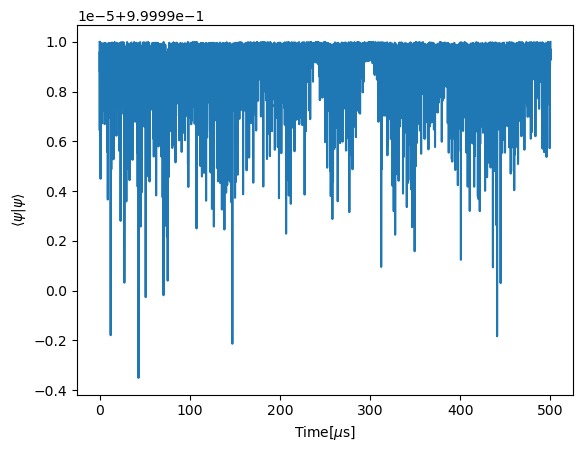

In [47]:
fb, sb, bases, a, Sx, Sy, Sz, idOp = make_operators(4, 100)
plot(tout, expect(idOp, psi_t))
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle \\psi | \\psi \\rangle\$")
PyPlot.display_figs()

In [37]:
W(0.1)

(0.2384303867108135 - 0.3203593358009233im, -0.8781749128519063 - 0.20590953906942272im)

In [ ]:
white_noise = zeros(ComplexF64, length(tout))
prev_index = 1
new_index = 1
for i = 2:length(tout)
    new_index = prev_index
    while W.t[new_index] < tout[i]
        new_index += 1
    end
    white_noise[i] = (W.u[new_index] - W.u[prev_index])/(tout[i] - tout[i-1])
    prev_index = new_index
end

In [11]:
seed = 26
λrel = 1.0
κ=200.0

tout, psi_t, W, fb, sb, bases, a, Sx, Sy, Sz = single_run_dicke_hetrodyne(seed, λrel, κ=κ, tmax=500.0, Nspin=100);

Running with seed: 24

In [8]:
seed = 24
λrels = LinRange(0.0, 3.0, 30)
λrel = λrels[25]
tout = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "tout");
psi_t = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "psi_t");
W = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "W");

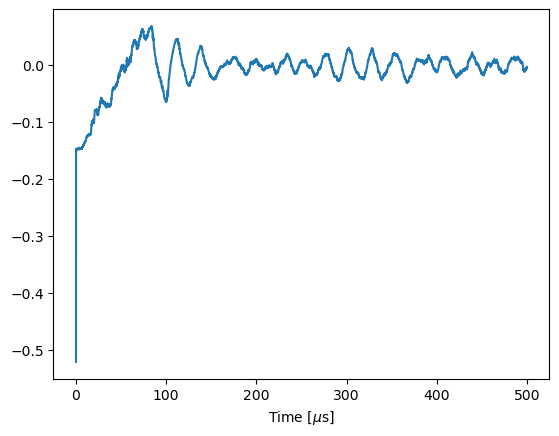

In [14]:
fb, sb, bases, a, Sx, Sy, Sz = make_operators(4, 100)
plot(tout, expect(a, psi_t))
xlabel("Time [\$\\mu\$s]")
ylabel("\$\\langle a \\rangle\$")
PyPlot.display_figs()

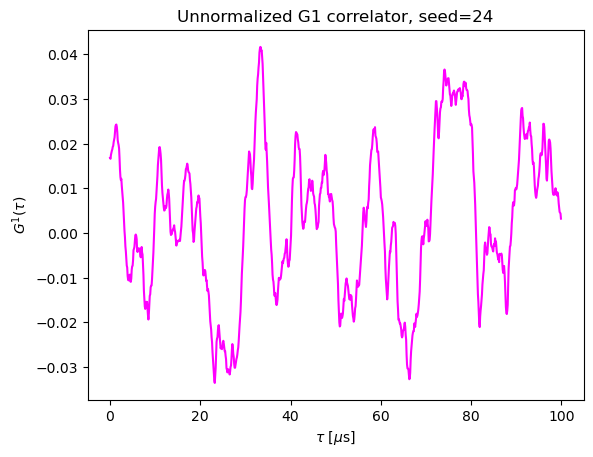

In [13]:
# seeds = [42, 1337, 1729, 724, 333, 137, 31459, 271828, 24, 240]
seed = 24
λrels = LinRange(0.0, 3.0, 30)
# short_list = λrels[1:7]
cm = get_cmap(:spring)
κ=200.0
fb, sb, bases, a, Sx, Sy, Sz = make_operators(4, 100)

for λrel in λrels[1:1]
    tout = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "tout");
    psi_t = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "psi_t");
    W = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "W");


    white_noise = zeros(ComplexF64, length(tout))
    prev_index = 1
    new_index = 1
    for i = 2:length(tout)
        new_index = prev_index
        while W.t[new_index] < tout[i]
            new_index += 1
        end
        white_noise[i] = (W.u[new_index] - W.u[prev_index])/(tout[i] - tout[i-1])
        prev_index = new_index
    end

    Jhet = sqrt(2*κ)*expect(a, psi_t) + conj(white_noise);
    dt = tout[2] - tout[1]
    tau = dt*10
    Jhetfilt = exp_filter(Jhet, tau, dt)
    time_bins = 1000
    time = tout[1:time_bins]

    Background = exp.(-time/tau)/(dt)*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau))

    # plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins))#  - Background
    # plot(time, Background)
    plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins) - Background, color=cm(λrel/λrels[end]), label="$(round(λrel,digits=2))")
    # plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins) - two_point_correlator(exp_filter(conj(white_noise), tau, dt), tout, dt, time_bins))
end
# legend()
xlabel(L"$\tau$ [$\mu$s]")
ylabel(L"$G^1 (\tau)$")
# PyPlot.colorbar()
PyPlot.title("Unnormalized G1 correlator, seed=$(seed)")
PyPlot.display_figs()

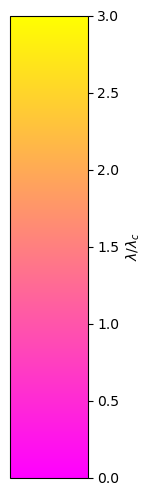

In [25]:
fig, ax = PyPlot.subplots(figsize=(1,6))
cm = get_cmap(:spring)
norm = matplotlib[:colors][:Normalize](vmin=0.0, vmax=3.0)
cb1 = matplotlib[:colorbar][:ColorbarBase](ax, cmap=cm, norm=norm)
cb1.set_label("\$\\lambda/\\lambda_c\$")
PyPlot.display_figs()

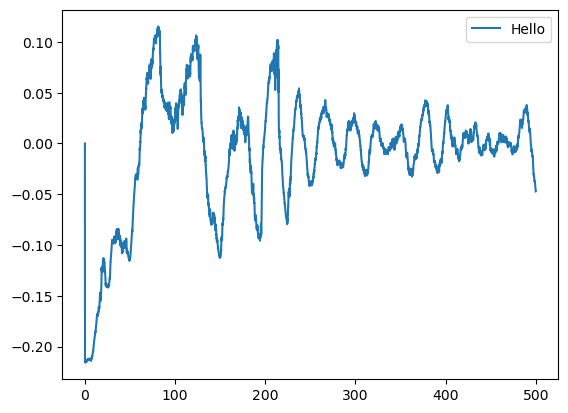

In [53]:
plot(tout, imag.(expect(a, psi_t)), label="Hello")
legend()
PyPlot.display_figs()

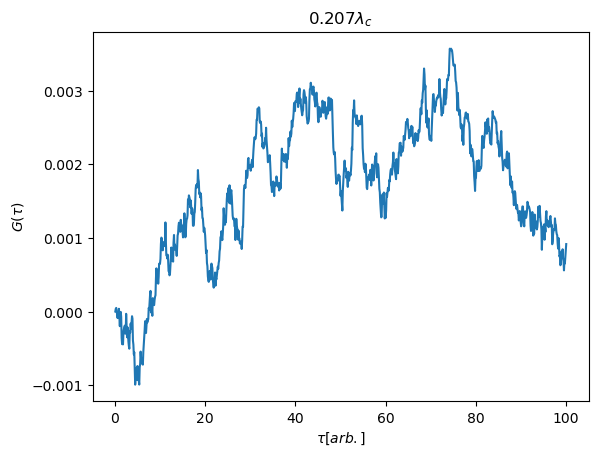

In [27]:
seeds = [42, 1337, 1729, 724, 333, 137, 31459, 271828, 24, 240]
seed = 42
λrel = 0.207
κ=200.0
tout = load("DickeModelRslts4/seed=$(seed)lambda=$(λrel).jld2", "tout");
psi_t = load("DickeModelRslts4/seed=$(seed)lambda=$(λrel).jld2", "psi_t");
W = load("DickeModelRslts4/seed=$(seed)lambda=$(λrel).jld2", "W");

white_noise = zeros(ComplexF64, length(tout))
prev_index = 1
new_index = 1
for i = 2:length(tout)
    new_index = prev_index
    while W.t[new_index] < tout[i]
        new_index += 1
    end
    white_noise[i] = (W.u[new_index] - W.u[prev_index])/(tout[i] - tout[i-1])
    prev_index = new_index
end

Jhet = sqrt(2*κ)*expect(a, psi_t) + conj(white_noise);
dt = tout[2] - tout[1]
tau = dt*1000
time_bins = 1000
time = dt*collect(1:time_bins)

Background = zeros(length(time))
Background[1] = 1/dt

# plot(time, two_point_correlator(Jhet, tout, dt, time_bins))#  - Background
# plot(time, Background)
plot(time, exp_filter(two_point_correlator(Jhet, tout, dt, time_bins) - Background, tau, dt))
# plot(time, two_point_correlator(Jhet, tout, dt, time_bins) - two_point_correlator(conj(white_noise), tout, dt, time_bins))
xlabel(L"\tau [arb.]")
ylabel(L"$G(\tau)$")
PyPlot.title("$(λrel)\$\\lambda_c\$")
PyPlot.display_figs()

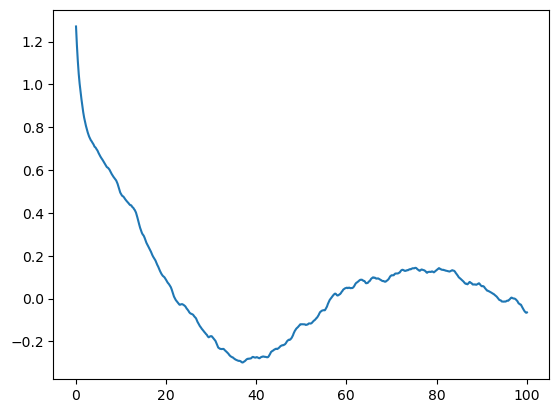

In [23]:
plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins) - two_point_correlator(exp_filter(conj(white_noise), tau, dt), tout, dt, time_bins))
PyPlot.display_figs()

In [70]:
two_point_correlator(Jhetfilt, tout, dt, 300)[2]

0.5062638157327481 + 0.00455229561347181im

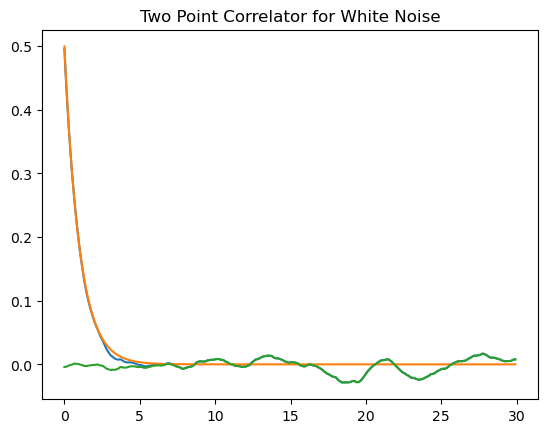

Pre-factor Actual: 0.49013553410966115-0.5106688003821964 	 Expected: 0.49953379120384234
 Decay time: 0.9883958362112918-1.050598005985766 	 Expected: 0.9999000000000001


In [10]:
W = WienerProcess(0.,im*0., im*0.)
time_total = LinRange(0.0,1000.0,10000)
time = time_total[1:300]
dt = time[2] - time[1]
tau = 10*dt
noise = make_white_noise(time_total, W)
filt_noise = exp_filter(noise, tau, dt)
Background = exp.(-time/tau)/dt*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau))
Bin_var = 1/dt

two_point = real.(two_point_correlator(filt_noise, time_total, dt, 300))

@. model(x,p) = p[1]*exp(-x*p[2])
fit = curve_fit(model, time,two_point, [1/(dt)*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau)), 1/tau])

Background = exp.(-time/tau)*(1/(dt)*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau)))

rslt = confidence_interval(fit, 0.1)
println("Pre-factor Actual: $(rslt[1][1])-$(rslt[1][2]) \t Expected: $(1/(dt)*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau)))\n Decay time: $(rslt[2][1])-$(rslt[2][2]) \t Expected: $(1/tau)")

# plot(time[1:300], two_point_correlator(noise, time, dt, 300))#  - Background
plot(time, two_point_correlator(filt_noise, time_total, dt, 300))
plot(time, Background)
# plot(time, two_point_correlator(noise, time_total, dt, 300))
# plot(time, Bin_var*ones(length(time)))
plot(time, two_point_correlator(filt_noise, time_total, dt, 300)-Background)
PyPlot.title("Two Point Correlator for White Noise")
PyPlot.display_figs()